# Reimplementation of the Cycle GAN including the implementation of different variations

In this project, we reimplement the paper "Unpaired Image-to-Image Translation
using Cycle-Consistent Adversarial Networks" and test its performance with three different datasets (two given by the paper and a new one). First, the introduced Cycle GAN is implemented as described in the paper (with minor justified changes). In addition, two modifications are applied, resulting in three different types of Cycle GANs:


1.   Classical Cycle GAN
2.   Regularized Cycle GAN
3.   Cycle Wasserstein GAN (Cycle WGAN)

Like the three different datasets, these can be selected by boolean. The goal of this project is to compare and analyze the training and test performances with the different types of Cycle GANs for the varying datasets.  






**Initialization**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds

# Import Tensorflow Addons for having access to the InstanceNormalization layer.
!pip install tensorflow-addons
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt

# Mount google drive to colab. 
from google.colab import drive
drive.mount("/gdrive")

# Import OS for navigation and environment setup.
import os
from os import path

# Import csv to store the training and test losses.
import csv

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


**Function to download the Kaggle dataset "Selfie2Anime"**

For using the Kaggle API to download this dataset, one needs to provide a Kaggle API token in the form of a file called "kaggle.json". You can find the token in the settings of your Kaggle account. Then, the token needs to be stored in "/gdrive/MyDrive/kaggle".

In [2]:
def download_kaggle_dataset_selfie2anime():
  # To enable the Kaggle environment, the path to the directory, where the Kaggle API token is stored in, is specified.
  os.environ["KAGGLE_CONFIG_DIR"] = "/gdrive/MyDrive/kaggle"
  # The Kaggle library is installed to enable Kaggle terminal commands.
  !pip install kaggle

  # Downlaod and unzip the dataset.
  os.chdir("/gdrive/MyDrive/kaggle")    
  !kaggle datasets download -d arnaud58/selfie2anime
  zip_path = "/gdrive/MyDrive/kaggle/selfie2anime.zip"
  !cp "{zip_path}" .
  !unzip -q "selfie2anime.zip"

**Dataset selection and preparation of the input pipeline**

In this code cell, the user can decide which dataset out of three should be used for training. The possible datasets are:

1.   Selfie2Anime
2.   Apple2Orange
3.   Monet2Photo

The chosen dataset is downloaded and prepared for the following input pipeline. 



In [3]:
# Boolean to choose which dataset is used for training.
is_selfie2anime_dataset = False   
is_apple2orange_dataset = True
is_monet2photo_dataset = False

if is_selfie2anime_dataset:           
  download_kaggle_dataset_selfie2anime()
  selfie2anime_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = "/gdrive/MyDrive/kaggle", shuffle = False, 
                                                                             class_names = ["trainA", "trainB", "testA", "testB"], batch_size = 1)

  # Limit values to seperate the dataset in the respective classes. Each train class consists of 3400 samples.
  splitting_limit_train_test = 6800                                                            
  splitting_limit_train_A_train_B = 3400                                                       
  selfie2anime_train_data = selfie2anime_dataset.take(splitting_limit_train_test)                 
  selfie2anime_train_data_A = selfie2anime_train_data.take(splitting_limit_train_A_train_B)        
  selfie2anime_train_data_B = selfie2anime_train_data.skip(splitting_limit_train_A_train_B)        

  # Each test class consists of 100 samples.
  splitting_limit_test_A_test_B = 100                                                          
  selfie2anime_test_data = selfie2anime_dataset.skip(splitting_limit_train_test)                
  selfie2anime_test_data_A = selfie2anime_test_data.take(splitting_limit_test_A_test_B)         
  selfie2anime_test_data_B = selfie2anime_test_data.skip(splitting_limit_test_A_test_B)          

  # The fourth dimension (batch) is removed, because the batched datasets are created together with the labels later during training.
  train_data_A = selfie2anime_train_data_A.map(lambda img, lbl: tf.reshape(img, [256, 256, 3])) 
  train_data_B = selfie2anime_train_data_B.map(lambda img, lbl: tf.reshape(img, [256, 256, 3]))  
  test_data_A = selfie2anime_test_data_A.map(lambda img, lbl: tf.reshape(img, [256, 256, 3]))
  test_data_B = selfie2anime_test_data_B.map(lambda img, lbl: tf.reshape(img, [256, 256, 3]))   

elif is_apple2orange_dataset:
  train_data_A, train_data_B, test_data_A, test_data_B = tfds.load("cycle_gan/apple2orange", split = ["trainA", "trainB", "testA", "testB"], 
                                                                   as_supervised = True)    
elif is_monet2photo_dataset:
  train_data_A, train_data_B, test_data_A, test_data_B = tfds.load("cycle_gan/monet2photo", split = ["trainA", "trainB", "testA", "testB"], 
                                                                   as_supervised = True) 

# The labels of the two tf.datasets are removed, because they are not needed for training.
if is_apple2orange_dataset or is_monet2photo_dataset:             
  train_data_A = train_data_A.map(lambda img, lbl: img)          
  train_data_B = train_data_B.map(lambda img, lbl: img)      
  test_data_A = test_data_A.map(lambda img, lbl: img)        
  test_data_B = test_data_B.map(lambda img, lbl: img)

**Input pipeline**

The train and test class sizes of the datasets are always set to 900 and 100 to ensure a better comparibility of the training processes with the different datasets. The images are resized to 128x128 to enable faster training. 

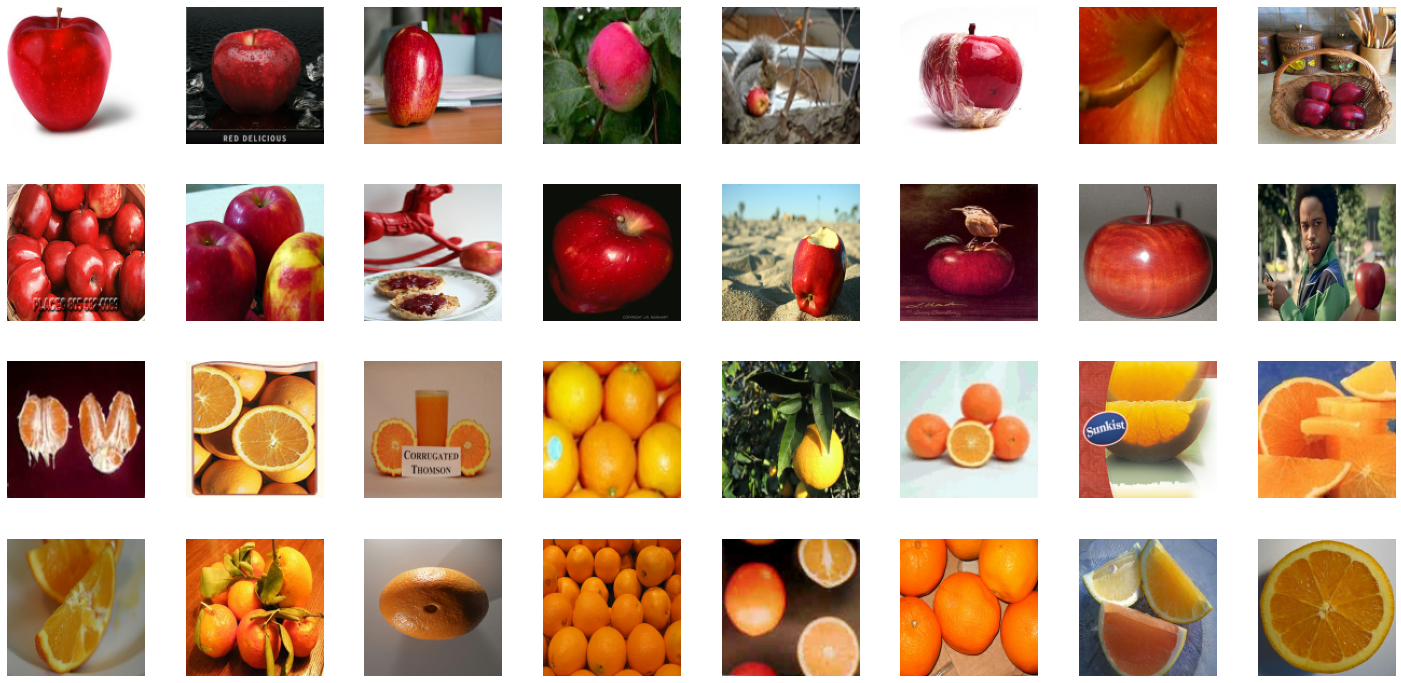

In [4]:
# Same number of training and test samples for each dataset
n_train_samples = 900                           
n_test_samples = 100
train_A = train_data_A.take(n_train_samples)
train_B = train_data_B.take(n_train_samples)
test_A = test_data_A.take(n_test_samples)
test_B = test_data_B.take(n_test_samples)

# The images are resized to 128x128 to enable faster training. 
train_A = train_A.map(lambda img: tf.image.resize(img, [128, 128], method = "bilinear", antialias = False))
train_B = train_B.map(lambda img: tf.image.resize(img, [128, 128], method = "bilinear", antialias = False))      
test_A = test_A.map(lambda img: tf.image.resize(img, [128, 128], method = "bilinear", antialias = False))        
test_B = test_B.map(lambda img: tf.image.resize(img, [128, 128], method = "bilinear", antialias = False)) 

# Normalize images.
train_A = train_A.map(lambda img: 2 * (img / 255) - 1)     
train_B = train_B.map(lambda img: 2 * (img / 255) - 1)      
test_A = test_A.map(lambda img: 2 * (img / 255) - 1)        
test_B = test_B.map(lambda img: 2 * (img / 255) - 1)  

# Shuffle and prefetch the datasets. Batching is conducted later when the datasets are complete.
train_A = train_A.shuffle(buffer_size = 128).prefetch(buffer_size = 128)
train_B = train_B.shuffle(buffer_size = 128).prefetch(buffer_size = 128)
test_A = test_A.shuffle(buffer_size = 128).prefetch(buffer_size = 128)      
test_B = test_B.shuffle(buffer_size = 128).prefetch(buffer_size = 128)

# Display some images from the two domains. 
fig, ax = plt.subplots(4, 8, figsize=(20, 10))
fig.tight_layout()
ax = ax.flatten()
i = 0
for img in train_A:     
  if i < 16:
    ax[i].imshow((img.numpy() + 1) / 2)   
    ax[i].axis("off")                       
    i += 1
  else:
    break
for img in train_B:     
  if i < 32:         
    ax[i].imshow((img.numpy() + 1) / 2) 
    ax[i].axis("off")                         
    i += 1
  else:
    break

**Helper functions to, among other things, conduct the creation of real and fake/ generated image datasets.**

In [5]:
# batch_size = 1 applies to all datasets used, as in the Cycle GAN Paper. 
batch_size = 1

# This function returns a real_dataset consisting of one real image taken from the given domain 
# and the respective label of shape: "patch_shape" x "patch_shape".                                                                                                              
def generate_real_dataset(real_samples_current_domain, patch_shape):
  random_idx = np.random.randint(0, real_samples_current_domain.__len__())     
  real_img = real_samples_current_domain.shard(num_shards = real_samples_current_domain.__len__(), index = random_idx)

  # The discriminator label has the shape of a quadratic patch instead of a single value.   
  real_img_label = tf.ones(shape = [1, patch_shape, patch_shape, 1], dtype = tf.dtypes.int8)        
  real_img_label = tf.data.Dataset.from_tensor_slices(real_img_label)         

  # The complete dataset is batched with batch_size = 1, as in the Cycle GAN paper.
  real_dataset = tf.data.Dataset.zip((real_img, real_img_label))
  real_dataset = real_dataset.batch(batch_size)       
  return real_dataset

# This function returns a fake_dataset consisting of one fake image from the opposite domain than 
# the given one and the respective label of shape: "patch_shape" x "patch_shape".
def generate_fake_dataset(generator, real_sample_different_domain, patch_shape, Regularized_Cycle_GAN = False):
  fake_img = generator(real_sample_different_domain, Regularized_Cycle_GAN, False)
  fake_img = tf.data.Dataset.from_tensor_slices(fake_img)                                      

  # The discriminator label has the shape of a quadratic patch instead of a single value. 
  fake_img_label = tf.zeros(shape = [1, patch_shape, patch_shape, 1], dtype = tf.dtypes.int8)         
  fake_img_label = tf.data.Dataset.from_tensor_slices(fake_img_label)                     

  # The complete dataset is batched with batch_size = 1, as in the Cycle GAN paper.
  fake_dataset = tf.data.Dataset.zip((fake_img, fake_img_label))
  fake_dataset = fake_dataset.batch(batch_size)
  return fake_dataset

# This function manages the image_pools which are introduced in the Cycle GAN paper to update
# the discriminators using a history of generated images rather than the latest created ones. 
def update_image_pool(pool, fake_dataset, max_pool_size = 50):       
  selected_img = []                                     
  for img, lbl in fake_dataset:
    # If the pool is not filled yet, append the image and take it as the "selected image".
    if len(pool) < max_pool_size:
      pool.append(img)
      selected_img = img
    # If the pool is filled, take an image from it and replace this image with the new image.
    else:
      random_idx = np.random.randint(0, len(pool))    
      selected_img = pool[random_idx] 
      pool[random_idx] = img
    
    # Create the "new" dataset with the image taken from the pool. The label remains the same.
    fake_img = tf.data.Dataset.from_tensor_slices(selected_img)  
    fake_img_label = tf.data.Dataset.from_tensor_slices(lbl)            
    fake_dataset = tf.data.Dataset.zip((fake_img, fake_img_label))
    fake_dataset = fake_dataset.batch(batch_size)
  return fake_dataset

# This function determines "n_samples" images from the given domain which are used to regularly
# generate images from the other domain to enable the qualitative evaluation of the training progress.
def determine_evaluation_images(real_samples_current_domain, n_samples):
  evaluation_imgs_current_domain = []
  for _ in range(n_samples):
    random_idx = np.random.randint(0, real_samples_current_domain.__len__())
    img_dataset = real_samples_current_domain.shard(num_shards = real_samples_current_domain.__len__(), index = random_idx)
    
    # The dataset must be batched to be suitable for later processing by TF layers.
    img_dataset = img_dataset.batch(batch_size)                         
    for img in img_dataset:      
      evaluation_imgs_current_domain.append(img)           
  return evaluation_imgs_current_domain

# This function generates images from the opposite domain than the given ones. These generated
# images are used for the qualitative evaluation of the training progress. 
@tf.function
def generate_images_from_different_domain(generator, evaluation_imgs_current_domain, Regularized_Cycle_GAN = False):
  generated_imgs_different_domain = []
  for img in evaluation_imgs_current_domain:
    fake_img = generator(img, Regularized_Cycle_GAN, False)               
    generated_imgs_different_domain.append(tf.squeeze(fake_img))
  return generated_imgs_different_domain

**Class ResNet_Block (Part Of the Cycle GAN's generator)**

In [6]:
# The class ResNet_Block defines the ResNet blocks of a classical Cycle GAN and a Cycle WGAN. It consists of two 3×3 CNN layers with
# "n_filters" each. Additionally, the input of the block is concatenated channel-wise with the output of the block. The instances
# of this class are part of the generator. In contrast to the paper, same padding instead of reflection padding is used here. 
# The default value for "n_filters" is 64 and not 256 to reduce the complexity and enable a faster training of the GAN.
class ResNet_Block(tf.keras.layers.Layer): 
  
  def __init__(self, n_filters = 64):
    super(ResNet_Block, self).__init__()

    self.layers = [
                   tf.keras.layers.Conv2D(filters = n_filters,
                                          kernel_size = (3,3),
                                          strides = (1,1),
                                          activation = None,
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)),       
                   tfa.layers.InstanceNormalization(axis = -1),                                     
                   tf.keras.layers.ReLU(),
                   
                   tf.keras.layers.Conv2D(filters = n_filters,
                                          kernel_size = (3,3),
                                          strides = (1,1),
                                          activation = None,
                                          padding = "same",    
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)),
                    tfa.layers.InstanceNormalization(axis = -1)
    ] 

    self.concat = tf.keras.layers.Concatenate()    

  # This function conducts a forward step of the ResNet_Block. There is no parameter "train" to distinguish between a training-
  # and a test call, as no layer requires this here (Note: InstanceNormalization layers are kept during testing).
  @tf.function
  def call(self, block_input):
    x = block_input
    for layer in self.layers:
      x = layer(x)    

    block_output = self.concat([x, block_input])
    return block_output          

**Class Regularized_ResNet_Block (Part Of the Cycle GAN's generator)**



In [7]:
# The class Reglarized_ResNet_Block defines the ResNet blocks of a Regularized Cycle GAN and consists of two 3×3 CNN layers with
# "n_filters" each. Additionally, the input of the block is concatenated channel-wise with the output of the block. The instances
# of this class are part of the generator. In contrast to the paper, same padding instead of reflection padding is used here.
# The default value for "n_filters" is 64 and not 256 to reduce the complexity and enable a faster training of the GAN.
# The difference to a classical ResNet_Block is the additional Dropout layer after the first CNN layer. This regularization technique
# is one of the two introduced changes of a Regularized Cycle GAN compared to a classical one.
class Regularized_ResNet_Block(tf.keras.layers.Layer): 
  
  def __init__(self, n_filters = 64):
    super(Regularized_ResNet_Block, self).__init__()

    self.layers = [                  
                   tf.keras.layers.Conv2D(filters = n_filters,
                                          kernel_size = (3,3),
                                          strides = (1,1),
                                          activation = None,
                                          padding = "same",     
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)),        
                   tfa.layers.InstanceNormalization(axis = -1),                                     
                   tf.keras.layers.ReLU(),
                   # Dropout Layer as addtional regularization technique
                   tf.keras.layers.Dropout(rate = 0.5),     
                   
                   tf.keras.layers.Conv2D(filters = n_filters,
                                          kernel_size = (3,3),
                                          strides = (1,1),
                                          activation = None,
                                          padding = "same",    
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)),
                   tfa.layers.InstanceNormalization(axis = -1)
    ]   

    self.concat = tf.keras.layers.Concatenate()   

  # This function conducts a forward step of the Regularized_ResNet_Block. Here, the parameter "train" to distinguish between a training-
  # and a test call is necessary, as the Dropout layer requires it.
  @tf.function                                               
  def call(self, block_input, train = True):
    x = block_input
    for layer in self.layers:
      x = layer(x, training = train)    

    block_output = self.concat([x, block_input])
    return block_output                 

**Class Cycle_GAN_Generator**

In [8]:
# The class Cycle_GAN_Generator defines the generator of a Cycle GAN. In contrast to the ResNet block and the discriminator,
# there is no additional generator class for one of the three different types of Cycle GANs necessary. Nevertheless, this class 
# allows to distinguish between classical Cycle GAN/ Cycle WGAN and a Regularized Cycle GAN since the generators of these types 
# differ in their ResNet blocks (also called Transformation part).
# In contrast to the paper, same padding instead of reflection padding is used and the filter sizes are quartered to reduce the
# complexity and enable a faster training of the Cycle GAN.
class Cycle_GAN_Generator(tf.keras.layers.Layer): 
  
  def __init__(self, Regularized_Cycle_GAN = False, image_shape = (128, 128, 3), n_resnet = 6):
    super(Cycle_GAN_Generator, self).__init__()

    self.encoding = [
                     tf.keras.layers.Conv2D(filters = 16, 
                                            kernel_size = (7,7),
                                            strides = (1,1),
                                            activation = None,
                                            padding = "same",    
                                            kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                            input_shape = image_shape),                                                
                     tfa.layers.InstanceNormalization(axis = -1),                                     
                     tf.keras.layers.ReLU(),
                     
                     tf.keras.layers.Conv2D(filters = 32, 
                                            kernel_size = (3,3),
                                            strides = (2,2),
                                            activation = None,
                                            padding = "same",    
                                            kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)),
                     tfa.layers.InstanceNormalization(axis = -1),
                     tf.keras.layers.ReLU(),
                     
                     tf.keras.layers.Conv2D(filters = 64,   
                                           kernel_size = (3,3),
                                           strides = (2,2),
                                           activation = None,
                                           padding = "same",    
                                           kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)),
                     tfa.layers.InstanceNormalization(axis = -1),                                     
                     tf.keras.layers.ReLU()
    ]

    self.resnet_blocks = []
    for _ in range(n_resnet):
      # Distinguishing between classical Cycle GAN/ Cycle WGAN and a Regularized Cycle GAN via boolean 
      if Regularized_Cycle_GAN:
        self.resnet_blocks.append(Regularized_ResNet_Block(n_filters = 64))   
      else:
        self.resnet_blocks.append(ResNet_Block(n_filters = 64))   

    self.decoding = [
                     tf.keras.layers.Conv2DTranspose(filters = 32, 
                                                     kernel_size = (3,3),               
                                                     strides = (2,2),
                                                     activation = None,
                                                     padding = "same",
                                                     kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)),
                     tfa.layers.InstanceNormalization(axis = -1),                                     
                     tf.keras.layers.ReLU(),
                     
                     tf.keras.layers.Conv2DTranspose(filters = 16,  
                                                     kernel_size = (3,3),               
                                                     strides = (2,2),
                                                     activation = None,
                                                     padding = "same",
                                                     kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)),
                     tfa.layers.InstanceNormalization(axis = -1),                                     
                     tf.keras.layers.ReLU(),
                     
                     tf.keras.layers.Conv2D(filters = 3,
                                            kernel_size = (7,7),
                                            strides = (1,1),
                                            activation = None,
                                            padding = "same",    
                                            kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)),
                     tfa.layers.InstanceNormalization(axis = -1),                                         
                     tf.keras.activations.tanh
    ]

  # This function conducts a forward step of the Cycle_GAN_Generator. Here, the parameter "train" to distinguish between a training-
  # and a test call is necessary, as the possible choice of the type Regularized Cycle GAN with its regularized ResNet blocks requires it.
  @tf.function
  def call(self, x, Regularized_Cycle_GAN = False, train = True):
    for layer in self.encoding:
      x = layer(x)  

    for block in self.resnet_blocks:
      # Regularized Cycle GAN needs the "train" argument.
      if Regularized_Cycle_GAN:
        x = block(x, train)
      # Classical Cycle GAN and Cycle WGAN do not need the "train" argument.
      else:
        x = block(x)                  

    for layer in self.decoding:
      x = layer(x)

    return x    

**Class Cycle_GAN_Discriminator**

In [9]:
# The class Cycle_GAN_Discriminator defines the discriminator of a classical Cycle GAN and a Regularized Cycle GAN. Instead of
# outputting a single value like the discriminator of a normal GAN, it outputs a square of predictions, called patch. As
# activation of the patch output layer Sigmoid is used to obtain values between 0 and 1. This is not explicitly mentioned in the 
# paper, but is a selectable option in the provided implementation on github.
# In contrast to the paper, same padding instead of reflection padding is used and the filter sizes are quartered to reduce the
# complexity and enable a faster training of the Cycle GAN.
# As second regularization technique of the Regularized Cycle GAN a L2 regularization loss based on the weights is applied. It is 
# calculated for both classical and regularized Cycle GAN, but is only added to the discriminator loss in the respective training 
# step of a Regularized Cycle GAN. This again happens depending on on the boolean "Regularized_Cycle_GAN".  
class Cycle_GAN_Discriminator(tf.keras.layers.Layer): 
  
  def __init__(self, image_shape = (128, 128, 3)):
    super(Cycle_GAN_Discriminator, self).__init__()       

    self.layers = [
                   tf.keras.layers.Conv2D(filters = 16,
                                          kernel_size = (4,4),
                                          strides = (2,2),
                                          activation = None,
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                          # L2 regularization loss for the Regularized Cycle GAN
                                          kernel_regularizer = tf.keras.regularizers.L2(0.01),                              
                                          input_shape = image_shape),
                   tf.keras.layers.LeakyReLU(alpha = 0.2),                        
                   
                   tf.keras.layers.Conv2D(filters = 32,  
                                          kernel_size = (4,4),
                                          strides = (2,2),
                                          activation = None,
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                          # L2 regularization loss for the Regularized Cycle GAN
                                          kernel_regularizer = tf.keras.regularizers.L2(0.01)),
                   tfa.layers.InstanceNormalization(axis = -1),  
                   tf.keras.layers.LeakyReLU(alpha = 0.2),  
                   
                   tf.keras.layers.Conv2D(filters = 64,  
                                          kernel_size = (4,4),
                                          strides = (2,2),
                                          activation = None,
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                          # L2 regularization loss for the Regularized Cycle GAN
                                          kernel_regularizer = tf.keras.regularizers.L2(0.01)),
                   tfa.layers.InstanceNormalization(axis = -1),
                   tf.keras.layers.LeakyReLU(alpha = 0.2),    
                   
                   tf.keras.layers.Conv2D(filters = 128,  
                                          kernel_size = (4,4),
                                          strides = (2,2),
                                          activation = None,
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                          # L2 regularization loss for the Regularized Cycle GAN
                                          kernel_regularizer = tf.keras.regularizers.L2(0.01)),
                   tfa.layers.InstanceNormalization(axis = -1),
                   tf.keras.layers.LeakyReLU(alpha = 0.2),     

                   # Patch output with Sigmoid activation
                   tf.keras.layers.Conv2D(filters = 1,
                                          kernel_size = (4,4),
                                          strides = (1,1),
                                          activation = tf.keras.activations.sigmoid,      
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                          # L2 regularization loss for the Regularized Cycle GAN
                                          kernel_regularizer = tf.keras.regularizers.L2(0.01))
    ]

  # This function conducts a forward step of the Cycle_GAN_Discriminator. There is no parameter "train" to distinguish between
  # a training- and a test call, as no layer requires this here (Note: InstanceNormalization layers are kept during testing).
  @tf.function
  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x            

**Class Cycle_WGAN_Discriminator (Cycle Wasserstein GAN Discriminator)**

In [10]:
# The class Cycle_WGAN_Discriminator defines the discriminator of a Cycle WGAN. Instead of outputting a single value like the
# discriminator of a normal GAN, it outputs a square of predictions, called patch. In contrast to the paper, same padding 
# instead of reflection padding is used and the filter sizes are quartered to reduce the complexity and enable a faster training 
# of the Cycle WGAN.
# Since it is a Wasserstein Discriminator, weight clipping is applied by defining the kernel_constraint and bias_constraint arguments. 
# In addition, a linear activation instead of Sigmoid activation for the patch output layer is used.
class Cycle_WGAN_Discriminator(tf.keras.layers.Layer): 
  
  def __init__(self, image_shape = (128, 128, 3)):
    super(Cycle_WGAN_Discriminator, self).__init__()       

    self.layers = [
                   tf.keras.layers.Conv2D(filters = 16, 
                                          kernel_size = (4,4),
                                          strides = (2,2),
                                          activation = None,
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),   
                                          # Weight clipping
                                          kernel_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),
                                          bias_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),                             
                                          input_shape = image_shape),
                   tf.keras.layers.LeakyReLU(alpha = 0.2),         
                   
                   tf.keras.layers.Conv2D(filters = 32,  
                                          kernel_size = (4,4),
                                          strides = (2,2),
                                          activation = None,
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                          # Weight clipping
                                          kernel_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),
                                          bias_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01)),
                   tfa.layers.InstanceNormalization(axis = -1), 
                   tf.keras.layers.LeakyReLU(alpha = 0.2),
                   
                   tf.keras.layers.Conv2D(filters = 64, 
                                          kernel_size = (4,4),
                                          strides = (2,2),
                                          activation = None,
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                          # Weight clipping
                                          kernel_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),
                                          bias_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01)),
                   tfa.layers.InstanceNormalization(axis = -1),
                   tf.keras.layers.LeakyReLU(alpha = 0.2),
                   
                   tf.keras.layers.Conv2D(filters = 128,  
                                          kernel_size = (4,4),
                                          strides = (2,2),
                                          activation = None,
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                          # Weight clipping
                                          kernel_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),
                                          bias_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01)),
                   tfa.layers.InstanceNormalization(axis = -1),
                   tf.keras.layers.LeakyReLU(alpha = 0.2),              
                   
                   # Patch output with linear activation (as it is a Wasserstein Discriminator)
                   tf.keras.layers.Conv2D(filters = 1,
                                          kernel_size = (4,4),
                                          strides = (1,1),
                                          activation = None, 
                                          padding = "same",  
                                          kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02),
                                          # Weight clipping
                                          kernel_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),
                                          bias_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01))
    ]

  # This function conducts a forward step of the Cycle_WGAN_Discriminator. There is no parameter "train" to distinguish between
  # a training- and a test call, as no layer requires this here (Note: InstanceNormalization layers are kept during testing).
  @tf.function
  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x        

**Training step functions for Generator and Discriminator**

In [11]:
# This function conducts a forward-step and the backpropagation of a generator (no matter what type of Cycle GAN is trained). Additionally, 
# the different components of the weighted overall loss and the weighted overall loss itself are returned. The identity loss is only used 
# for painting datasets in the paper. However, for better comparability, we decided to use it for all our datasets. 
# The boolean "Regularized_Cycle_GAN" is used to enable the generators calling the call function of the ResNet blocks in the correct way 
# (dependent on whether a classical Cycle GAN/ Cycle WGAN or a Regularized Cycle GAN is trained).
def generator_train_step(generator_1, generator_2, discriminator, source_domain_real_img, target_domain_real_img, target_domain_real_lbl, 
                         gen_loss_fn, dis_loss_fn, optimizer, Regularized_Cycle_GAN = False, gen1_train = True, gen2_train = False):
  with tf.GradientTape() as tape:
    # Adversarial loss -> Discriminator element. 
    gen1_out = generator_1(source_domain_real_img, Regularized_Cycle_GAN, gen1_train)   
    dis_out = discriminator(gen1_out)     
    # The target is the "target_domain_real_lbl", because the generator should fool the discriminator.                  
    adv_loss = dis_loss_fn(target_domain_real_lbl, dis_out)

    # Identity loss (in the paper only used for painting datasets)
    id_out = generator_1(target_domain_real_img, Regularized_Cycle_GAN, gen1_train)
    # The target is the "target_domain_real_img" again, because an image from the target domain should not be translated (Goal: Prediction = Input).
    id_loss = gen_loss_fn(target_domain_real_img, id_out)

    # Cycle consistency loss part 1 -> Forward cycle
    for_out = generator_2(gen1_out, Regularized_Cycle_GAN, gen2_train)
    # The target is the "source_domain_real_img", because the output after two generators should be the input of the first generator again.
    for_loss = gen_loss_fn(source_domain_real_img, for_out)

    # Cycle consistency loss part 2 -> Backward cycle
    gen2_out = generator_2(target_domain_real_img, Regularized_Cycle_GAN, gen2_train)
    back_out = generator_1(gen2_out, Regularized_Cycle_GAN, gen1_train)
    # The target is the "target_domain_real_img", because the output after two generators should be the input of the first generator again.
    back_loss = gen_loss_fn(target_domain_real_img, back_out)

    # Weighted overall loss as defined in the paper                    
    train_loss = ((1 * adv_loss) + (10 * (for_loss + back_loss)) + (5 * id_loss)) / 16  
    # Only "generator_1" is trained.
    gradients = tape.gradient(train_loss, generator_1.trainable_variables)
  optimizer.apply_gradients(zip(gradients, generator_1.trainable_variables))

  return [adv_loss, id_loss, for_loss, back_loss, train_loss]

# This function conducts a forward-step and the backpropagation of a discriminator (no matter what type of Cycle GAN is trained). Additionally, 
# the discriminator loss is returned. As in the paper, the discriminator loss is halved during training to slow down the rate at which the
# discriminator learns.
# The boolean "Regularized_Cycle_GAN" is used to decide whether the L2 regularization loss is added to the loss or not (dependent on whether
# a classical Cycle GAN/ Cycle WGAN or a Regularized Cycle GAN is trained).
def discriminator_train_step(discriminator, train_dataset, loss_fn, optimizer, Regularized_Cycle_GAN = False):
  for img, lbl in train_dataset:
    with tf.GradientTape() as tape:
      pred = discriminator(img)         
      # Distinguishing between classical Cycle GAN/ Cycle WGAN and a Regularized Cycle GAN via boolean 
      if Regularized_Cycle_GAN:
        # Add L2 regularization loss.
        train_loss = loss_fn(lbl, pred) + tf.math.reduce_sum(discriminator.losses)
      else:
        train_loss = loss_fn(lbl, pred)        
      # Devide the loss by 2 to slow down the rate at which the discriminator learns.
      gradients = tape.gradient((train_loss / 2), discriminator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
  
  return train_loss           

**Test step functions for Generator and Discriminator**

In [12]:
# This function conducts a test step of a generator (no matter what type of Cycle GAN is trained). Therefore, the different components of 
# the weighted overall loss and the weighted overall loss itself are returned. 
# The boolean "Regularized_Cycle_GAN" is used to enable the generators calling the call function of the ResNet blocks in the correct way 
# (dependent on whether a classical Cycle GAN/ Cycle WGAN or a Regularized Cycle GAN is trained).
def generator_test_step(generator_1, generator_2, discriminator, source_domain_real_img, target_domain_real_img, target_domain_real_lbl, 
                        gen_loss_fn, dis_loss_fn, Regularized_Cycle_GAN = False, gen1_train = False, gen2_train = False):  
  # Adversarial loss -> Discriminator element. 
  gen1_out = generator_1(source_domain_real_img, Regularized_Cycle_GAN, gen1_train)   
  dis_out = discriminator(gen1_out)                
  # The target is the "target_domain_real_lbl", because the generator should fool the discriminator.          
  adv_loss = dis_loss_fn(target_domain_real_lbl, dis_out)

  # Identity loss (in the paper only used for painting datasets)
  id_out = generator_1(target_domain_real_img, Regularized_Cycle_GAN, gen1_train) 
  # The target is the "target_domain_real_img" again, because an image from the target domain should not be translated (Goal: Prediction = Input).
  id_loss = gen_loss_fn(target_domain_real_img, id_out)

  # Cycle consistency loss part 1 -> Forward cycle
  for_out = generator_2(gen1_out, Regularized_Cycle_GAN, gen2_train)
  # The target is the "source_domain_real_img", because the output after two generators should be the input of the first generator again.
  for_loss = gen_loss_fn(source_domain_real_img, for_out)

  # Cycle consistency loss part 2 -> Backward cycle
  gen2_out = generator_2(target_domain_real_img, Regularized_Cycle_GAN, gen2_train)
  back_out = generator_1(gen2_out, Regularized_Cycle_GAN, gen1_train)
  # The target is the "target_domain_real_img", because the output after two generators should be the input of the first generator again.
  back_loss = gen_loss_fn(target_domain_real_img, back_out)

  # Weighted overall loss as defined in the paper                        
  test_loss = ((1 * adv_loss) + (10 * (for_loss + back_loss)) + (5 * id_loss)) / 16

  return [adv_loss, id_loss, for_loss, back_loss, test_loss]

# This function conducts a test step of a discriminator (no matter what type of Cycle GAN is trained). Therefore, the discriminator loss 
# is returned.
def discriminator_test_step(discriminator, test_dataset, loss_fn):
  for img, lbl in test_dataset:
    pred = discriminator(img)         
    test_loss = loss_fn(lbl, pred)        
  
  return test_loss 

**Helper functions to, among other things, save the losses and the evaluation/ generated images.**

In [13]:
# This function processes the average losses for the passed "_losses" lists (no matter if training or test losses). These average 
# losses are written to the passed "..._losses_for_vis" lists. These lists are later used for visualization and saving in Google Drive.
def process_losses(generator_1_losses, generator_2_losses, discriminator_1_losses, discriminator_2_losses,
                   generator_1_losses_for_vis, generator_2_losses_for_vis, discriminator_1_losses_for_vis, 
                   discriminator_2_losses_for_vis, train = True):  
  generator_1_losses_averaged = np.mean(generator_1_losses, axis = 0)
  generator_2_losses_averaged = np.mean(generator_2_losses, axis = 0)
  generator_1_losses_for_vis.append(generator_1_losses_averaged)
  generator_2_losses_for_vis.append(generator_2_losses_averaged)
    
  discriminator_1_losses_averaged = np.mean(discriminator_1_losses)
  discriminator_2_losses_averaged = np.mean(discriminator_2_losses)
  discriminator_1_losses_for_vis.append(discriminator_1_losses_averaged)
  discriminator_2_losses_for_vis.append(discriminator_2_losses_averaged)

  generator_1_losses.clear()
  generator_2_losses.clear()
  discriminator_1_losses.clear()
  discriminator_2_losses.clear()

# This function visualizes the passed generator losses (no matter if training or test losses).
def visualize_generator_loss(gen_1_losses, gen_2_losses):
  kinds_of_losses = ["adversarial", "identity", "forward", "backward", "weighted overall"]

  for loss_iter in range(len(gen_1_losses[0])):
    plt.figure()
    plt.title("Generator " + kinds_of_losses[loss_iter] + " loss")
    line1, = plt.plot(gen_1_losses[:, loss_iter])
    line2, = plt.plot(gen_2_losses[:, loss_iter])
    plt.ylabel("Loss")
    plt.legend((line1, line2),("Generator A to B", "Generator B to A"))
    plt.show()

# This function visualizes the passed discriminator losses (no matter if training or test losses).
def visualize_discriminator_loss(dis_1_losses, dis_2_losses):
  plt.figure()
  plt.title("Discriminator loss")
  line1, = plt.plot(dis_1_losses)
  line2, = plt.plot(dis_2_losses)
  plt.ylabel("Loss")
  plt.legend((line1, line2),("Discriminator A", "Discriminator B"))
  plt.show()

# This function shows the passed "img" after adapting its pixel value range to [0, 1].
def show_image(img):
  plt.imshow((img + 1) / 2)
  plt.show()

# This function shows and updates the regularly generated images to enable the qualitative evaluation of the training progress.
def show_and_update_generated_images(generator_A_to_B, generator_B_to_A, evaluation_imgs_domain_A, evaluation_imgs_domain_B, 
                                     generated_imgs_domain_A, generated_imgs_domain_B, Regularized_Cycle_GAN):
  # Generate the respective images to the passed evaluation images (source domain images).
  current_generated_imgs_domain_B = generate_images_from_different_domain(generator_A_to_B, evaluation_imgs_domain_A, Regularized_Cycle_GAN) 
  current_generated_imgs_domain_A = generate_images_from_different_domain(generator_B_to_A, evaluation_imgs_domain_B, Regularized_Cycle_GAN)   
 
  # Show one generated example image for each domain with its respective evaluation image (source domain image).
  print("ORIGINAL IMAGE FROM DOMAIN A:")
  # Squeezing necessary as the evaluation images are batched to be suitable for processing by TF layers.
  show_image(np.array(tf.squeeze(evaluation_imgs_domain_A))[0])
  print("Respective generated image from domain B:")
  show_image(np.array(current_generated_imgs_domain_B)[0])

  print("ORIGINAL IMAGE FROM DOMAIN B:")
  # Squeezing necessary as the evaluation images are batched to be suitable for processing by TF layers.
  show_image(np.array(tf.squeeze(evaluation_imgs_domain_B))[0])
  print("Respective generated image from domain A:")
  show_image(np.array(current_generated_imgs_domain_A)[0])
      
  # Write the generated images to lists for later saving in Google Drive.
  generated_imgs_domain_A.append(current_generated_imgs_domain_A)
  generated_imgs_domain_B.append(current_generated_imgs_domain_B)

# This function creates, if not already existing, the folders for the different datasets and types of Cycle GANs in Google Drive. 
def create_folder_if_necessary(folder_path):
  if path.exists(folder_path) == False:
    os.mkdir(folder_path)

# This function saves the passed "losses" at "saving_folder_path" in Google Drive with the name "loss_file_name". The boolean 
# "is_generator" is used to differ between writing multiple rows for a generator or just one row for a discriminator.
def write_losses_to_csv_file(saving_folder_path, loss_file_name, header, losses, is_generator): 
  with open(saving_folder_path + loss_file_name + ".csv", "w") as f:      
    write = csv.writer(f)       
    write.writerow(header)
    # Distinguishing between generator (multiple losses) and discriminator (just one loss)
    if is_generator:
      write.writerows(losses)
    else: 
      write.writerow(losses)

# This function saves the passed "img" at "saving_folder_path" in Google Drive with the name "img_name". The argument "img_number" is
# necessary for the later allocation of the different images to the respective training step. 
def save_image(img, saving_folder_path, img_name, img_number):
  plt.imsave(saving_folder_path + img_name + img_number + ".png", img)

# This function saves the evaluation images which are used throughout the training to regularly generate images from the other domain
# to enable the qualitative evaluation of the training progress.
def save_evaluation_images(evaluation_imgs, saving_folder_path, domain_name):
  img_cnt = 0
  for img_dataset in evaluation_imgs:
    for img in img_dataset:
      img = (img.numpy() + 1) / 2
      save_image(img, saving_folder_path, "/Eval_Img_" + domain_name, str(img_cnt))
    img_cnt += 1

# This function saves the generated images which are used throughout the training to regularly evaluate the training progress qualitatively.
def save_generated_images(generated_imgs, saving_folder_path, domain_name):
  set_cnt = 0
  for img_set in generated_imgs:
    img_cnt = 0
    for img in img_set:
      img = (img.numpy() + 1) / 2
      save_image(img, saving_folder_path, "/Gen_Img_" + domain_name, str(set_cnt) + "_" + str(img_cnt))
      img_cnt += 1
    set_cnt += 1

# This function controls the saving of the losses and images to Google Drive at the end of each training epoch.
def save_losses_and_images(generator_A_to_B_losses_for_vis, generator_B_to_A_losses_for_vis, discriminator_A_losses_for_vis, 
                           discriminator_B_losses_for_vis, generator_A_to_B_test_losses_for_vis, generator_B_to_A_test_losses_for_vis, 
                           discriminator_A_test_losses_for_vis, discriminator_B_test_losses_for_vis, evaluation_imgs_domain_A,
                           evaluation_imgs_domain_B, generated_imgs_domain_A, generated_imgs_domain_B, Regularized_Cycle_GAN, Cycle_WGAN):
  # Create the folder for the respective dataset in Google Drive.
  dataset_path = ""
  if is_selfie2anime_dataset:     
    create_folder_if_necessary("/gdrive/MyDrive/Selfie2Anime")
    dataset_path = "/gdrive/MyDrive/Selfie2Anime"
  elif is_apple2orange_dataset:
    create_folder_if_necessary("/gdrive/MyDrive/Apple2Orange")
    dataset_path = "/gdrive/MyDrive/Apple2Orange"
  elif is_monet2photo_dataset:
    create_folder_if_necessary("/gdrive/MyDrive/Monet2Photo")
    dataset_path = "/gdrive/MyDrive/Monet2Photo"
  
  # Create the folder for the respective type of Cycle GAN in Google Drive.
  saving_folder_path = ""
  if Regularized_Cycle_GAN == False and Cycle_WGAN == False:
    create_folder_if_necessary(dataset_path + "/Classical_Cycle_GAN")
    saving_folder_path = dataset_path + "/Classical_Cycle_GAN"
  elif Regularized_Cycle_GAN == True and Cycle_WGAN == False:
    create_folder_if_necessary(dataset_path + "/Regularized_Cycle_GAN")
    saving_folder_path = dataset_path + "/Regularized_Cycle_GAN"  
  elif Regularized_Cycle_GAN == False and Cycle_WGAN == True:
    create_folder_if_necessary(dataset_path + "/Cycle_WGAN")
    saving_folder_path = dataset_path + "/Cycle_WGAN"    
  
  # Save the losses for the different generators and discriminators in Google Drive.
  generator_header = ["Adversarial loss", "Identity loss", "Forward loss", "Backward loss", "Weighted overall loss"]
  discriminator_header = ["Loss"]
  write_losses_to_csv_file(saving_folder_path, "/Generator_A_to_B_Losses", generator_header, generator_A_to_B_losses_for_vis, True)
  write_losses_to_csv_file(saving_folder_path, "/Generator_B_to_A_Losses", generator_header, generator_B_to_A_losses_for_vis, True)
  write_losses_to_csv_file(saving_folder_path, "/Discriminator_A_Losses", discriminator_header, discriminator_A_losses_for_vis, False)
  write_losses_to_csv_file(saving_folder_path, "/Discriminator_B_Losses", discriminator_header, discriminator_B_losses_for_vis, False)
  write_losses_to_csv_file(saving_folder_path, "/Generator_A_to_B_Test_Losses", generator_header, generator_A_to_B_test_losses_for_vis, True)
  write_losses_to_csv_file(saving_folder_path, "/Generator_B_to_A_Test_Losses", generator_header, generator_B_to_A_test_losses_for_vis, True)
  write_losses_to_csv_file(saving_folder_path, "/Discriminator_A_Test_Losses", discriminator_header, discriminator_A_test_losses_for_vis, False)
  write_losses_to_csv_file(saving_folder_path, "/Discriminator_B_Test_Losses", discriminator_header, discriminator_B_test_losses_for_vis, False)

  # Save the different evaluation images and generated images in Google Drive. 
  save_evaluation_images(evaluation_imgs_domain_A, saving_folder_path, "Domain_A_")
  save_evaluation_images(evaluation_imgs_domain_B, saving_folder_path, "Domain_B_")
  save_generated_images(generated_imgs_domain_A, saving_folder_path, "Domain_A_")
  save_generated_images(generated_imgs_domain_B, saving_folder_path, "Domain_B_")

**Test process**

In [14]:
# This function conducts the testing of the Cycle GAN (no matter what type of Cycle GAN is trained). It is called regularly 
# by the "conduct_training_and_testing" function after a certain number of training steps has been completed.
def conduct_testing(generator_A_to_B, generator_B_to_A, discriminator_A, discriminator_B, gen_loss_fn, dis_loss_fn, patch_size, 
                    Regularized_Cycle_GAN, generator_A_to_B_test_losses_for_vis, generator_B_to_A_test_losses_for_vis, 
                    discriminator_A_test_losses_for_vis, discriminator_B_test_losses_for_vis):
  # Buffer lists for saving the current test losses 
  generator_A_to_B_test_losses = []
  generator_B_to_A_test_losses = []
  discriminator_A_test_losses = []
  discriminator_B_test_losses = []

  # Test loop -> Each test process loops one time over the test datasets.
  for test_step in range(test_A.__len__()):      
    # Keep track of the test progress
    if test_step % 10 == 0:
      print("Test step " + str(test_step))

    # Create datasets (batch_size = 1) with a real sample for each domain.
    domain_A_real_dataset = generate_real_dataset(test_A, patch_size)
    domain_B_real_dataset = generate_real_dataset(test_B, patch_size)
    # Split the created datasets into "img" and "lbl" for the different test steps and generation of fake samples.
    for img, lbl in domain_A_real_dataset:
      domain_A_real_img = img 
      domain_A_real_lbl = lbl             
    for img, lbl in domain_B_real_dataset:
      domain_B_real_img = img  
      domain_B_real_lbl = lbl           

    # Create datasets (batch_size = 1) with a fake sample (generated image) for each domain.
    domain_A_fake_dataset = generate_fake_dataset(generator_B_to_A, domain_B_real_img, patch_size, Regularized_Cycle_GAN)
    domain_B_fake_dataset = generate_fake_dataset(generator_A_to_B, domain_A_real_img, patch_size, Regularized_Cycle_GAN)

    # Conduct one test step of generator_A_to_B and write the losses to the respective buffer list.      
    current_test_losses_generator_A_to_B = generator_test_step(generator_A_to_B, generator_B_to_A, discriminator_B, 
                                                               domain_A_real_img, domain_B_real_img, domain_B_real_lbl, 
                                                               gen_loss_fn, dis_loss_fn, Regularized_Cycle_GAN, False, False)
    generator_A_to_B_test_losses.append(current_test_losses_generator_A_to_B)
  
    # Conduct one test step of generator_B_to_A and write the losses to the respective buffer list.     
    current_test_losses_generator_B_to_A = generator_test_step(generator_B_to_A, generator_A_to_B, discriminator_A, 
                                                               domain_B_real_img, domain_A_real_img, domain_A_real_lbl, 
                                                               gen_loss_fn, dis_loss_fn, Regularized_Cycle_GAN, False, False)
    generator_B_to_A_test_losses.append(current_test_losses_generator_B_to_A)
  
    # Conduct two test steps of discriminator_A (1 real and 1 fake image) and write the losses to the respective buffer lists.  
    current_test_loss_discriminator_A_real = discriminator_test_step(discriminator_A, domain_A_real_dataset, dis_loss_fn) 
    discriminator_A_test_losses.append(current_test_loss_discriminator_A_real)
    current_test_loss_discriminator_A_fake = discriminator_test_step(discriminator_A, domain_A_fake_dataset, dis_loss_fn)  
    discriminator_A_test_losses.append(current_test_loss_discriminator_A_fake)

    # Conduct two test steps of discriminator_B (1 real and 1 fake image) and write the losses to the respective buffer lists.  
    current_test_loss_discriminator_B_real = discriminator_test_step(discriminator_B, domain_B_real_dataset, dis_loss_fn)  
    discriminator_B_test_losses.append(current_test_loss_discriminator_B_real)
    current_test_loss_discriminator_B_fake = discriminator_test_step(discriminator_B, domain_B_fake_dataset, dis_loss_fn)  
    discriminator_B_test_losses.append(current_test_loss_discriminator_B_fake)

  # At the end of the test process, call the "process_losses" function for calculating the average test losses and writing them to the 
  # passed "..._losses_for_vis" lists which are later used for visualization and saving in Google Drive.
  process_losses(generator_A_to_B_test_losses, generator_B_to_A_test_losses, discriminator_A_test_losses, discriminator_B_test_losses, 
                 generator_A_to_B_test_losses_for_vis, generator_B_to_A_test_losses_for_vis, discriminator_A_test_losses_for_vis, 
                 discriminator_B_test_losses_for_vis, False)                   

**Training process**

In [15]:
# This function conducts the training of the Cycle GAN (no matter what type of Cycle GAN is trained). In addition, it regularly calls the
# "conduct_testing" function and controls the visualization and saving of the training progress. 
def conduct_training_and_testing(generator_A_to_B, generator_B_to_A, discriminator_A, discriminator_B, optimizer, gen_loss_fn, dis_loss_fn, patch_size, 
                                 n_steps, n_dis_steps, Regularized_Cycle_GAN, Cycle_WGAN, generator_A_to_B_losses_for_vis, generator_B_to_A_losses_for_vis, 
                                 discriminator_A_losses_for_vis, discriminator_B_losses_for_vis, generator_A_to_B_test_losses_for_vis,
                                 generator_B_to_A_test_losses_for_vis, discriminator_A_test_losses_for_vis, discriminator_B_test_losses_for_vis):
  # Buffer lists for saving the current training losses
  generator_A_to_B_losses = []
  generator_B_to_A_losses = []
  discriminator_A_losses = []
  discriminator_B_losses = []

  # Determine the evaluation images and save them to a list for each domain.
  evaluation_imgs_domain_A = determine_evaluation_images(test_A, 5)
  evaluation_imgs_domain_B = determine_evaluation_images(test_B, 5)
  # Lists for saving the the regularly generated images
  generated_imgs_domain_A = []
  generated_imgs_domain_B = []

  # Buffer pools are used to keep a history of fake/ generated images for each domain. The discriminator is trained with randomly taken generated images 
  # from these pools. This procedure is recommended by the Cycle GAN paper.
  fake_pool_A = []
  fake_pool_B = []

  epoch_cnt = 0
  # Training loop
  for train_step in range(n_steps):
    # Keep track of the training progress.
    if train_step % 10 == 0:
      print("Train step " + str(train_step))

    # Additional nested for-loop to train the discriminator more often than the generator, if required by a Cycle WGAN ("n_dis_steps" = 5). For the other
    # types of Cycle GAN holds "n_dis_steps" = 1, so that the nested for-loop has no effects.  
    for dis_iter in range(n_dis_steps):
  
      # Create datasets (batch_size = 1) with a real sample for each domain.
      domain_A_real_dataset = generate_real_dataset(train_A, patch_size)
      domain_B_real_dataset = generate_real_dataset(train_B, patch_size)
      # Split the created datasets into "img" and "lbl" for the different training steps and generation of fake samples.
      for img, lbl in domain_A_real_dataset:
        domain_A_real_img = img 
        domain_A_real_lbl = lbl             
      for img, lbl in domain_B_real_dataset:
        domain_B_real_img = img  
        domain_B_real_lbl = lbl           

      # Create datasets (batch_size = 1) with a fake sample (generated image) for each domain.
      domain_A_fake_dataset = generate_fake_dataset(generator_B_to_A, domain_B_real_img, patch_size, Regularized_Cycle_GAN)
      domain_B_fake_dataset = generate_fake_dataset(generator_A_to_B, domain_A_real_img, patch_size, Regularized_Cycle_GAN)

      # Replace the fake samples (generated images) with one taken from the respective buffer pool.
      domain_A_fake_dataset = update_image_pool(fake_pool_A, domain_A_fake_dataset)
      domain_B_fake_dataset = update_image_pool(fake_pool_B, domain_B_fake_dataset)

      # Train the generators only if it's the first iteration of a Cycle WGAN (the other iterations are performed only to update the discriminators) 
      # or if it's a classical Cycle GAN/ Regularized Cycle GAN where the complete training step is repeated only once anyway.
      if (Cycle_WGAN and dis_iter < 1) or Cycle_WGAN == False:
        # Conduct one training step of generator_A_to_B and write the losses to the respective buffer list.  
        current_losses_generator_A_to_B = generator_train_step(generator_A_to_B, generator_B_to_A, discriminator_B, 
                                                               domain_A_real_img, domain_B_real_img, domain_B_real_lbl, 
                                                               gen_loss_fn, dis_loss_fn, optimizer, Regularized_Cycle_GAN, True, False)
        generator_A_to_B_losses.append(current_losses_generator_A_to_B)
  
        # Conduct one training step of generator_B_to_A and write the losses to the respective buffer list.   
        current_losses_generator_B_to_A = generator_train_step(generator_B_to_A, generator_A_to_B, discriminator_A, 
                                                               domain_B_real_img, domain_A_real_img, domain_A_real_lbl, 
                                                               gen_loss_fn, dis_loss_fn, optimizer, Regularized_Cycle_GAN, True, False)
        generator_B_to_A_losses.append(current_losses_generator_B_to_A)
  
      # Conduct two training steps of discriminator_A (1 real and 1 fake image) and write the losses to the respective buffer lists.
      current_loss_discriminator_A_real = discriminator_train_step(discriminator_A, domain_A_real_dataset, dis_loss_fn, optimizer, Regularized_Cycle_GAN) 
      discriminator_A_losses.append(current_loss_discriminator_A_real)
      current_loss_discriminator_A_fake = discriminator_train_step(discriminator_A, domain_A_fake_dataset, dis_loss_fn, optimizer, Regularized_Cycle_GAN)  
      discriminator_A_losses.append(current_loss_discriminator_A_fake)

      # Conduct two training steps of discriminator_B (1 real and 1 fake image) and write the losses to the respective buffer lists.
      current_loss_discriminator_B_real = discriminator_train_step(discriminator_B, domain_B_real_dataset, dis_loss_fn, optimizer, Regularized_Cycle_GAN)  
      discriminator_B_losses.append(current_loss_discriminator_B_real)
      current_loss_discriminator_B_fake = discriminator_train_step(discriminator_B, domain_B_fake_dataset, dis_loss_fn, optimizer, Regularized_Cycle_GAN)  
      discriminator_B_losses.append(current_loss_discriminator_B_fake)

    # The "process_losses" function for calculating the average training losses and writing them to the passed "..._losses_for_vis" lists is called every 
    # 150 training steps.
    if train_step % 150 == 149:       
      process_losses(generator_A_to_B_losses, generator_B_to_A_losses, discriminator_A_losses, discriminator_B_losses, generator_A_to_B_losses_for_vis,
                     generator_B_to_A_losses_for_vis, discriminator_A_losses_for_vis, discriminator_B_losses_for_vis, True) 

    # The "conduct_testing" function is called every 300 training steps, so the average test losses are calculated half as often as the average training
    # losses to reduce the computation time.
    if train_step % 300 == 299:                     
      conduct_testing(generator_A_to_B, generator_B_to_A, discriminator_A, discriminator_B, gen_loss_fn, dis_loss_fn, patch_size, 
                      Regularized_Cycle_GAN, generator_A_to_B_test_losses_for_vis, generator_B_to_A_test_losses_for_vis, 
                      discriminator_A_test_losses_for_vis, discriminator_B_test_losses_for_vis)
      
      show_and_update_generated_images(generator_A_to_B, generator_B_to_A, evaluation_imgs_domain_A, evaluation_imgs_domain_B, 
                                       generated_imgs_domain_A, generated_imgs_domain_B, Regularized_Cycle_GAN)

    # Visualize the average losses of the generators and discriminators every 450 training steps.
    if train_step % 450 == 449:     
      print("TRAIN LOSSES")
      visualize_generator_loss(np.array(generator_A_to_B_losses_for_vis), np.array(generator_B_to_A_losses_for_vis))
      visualize_discriminator_loss(discriminator_A_losses_for_vis, discriminator_B_losses_for_vis)
      # After the first 450 steps, no graphs for the average test losses are available yet, since they were calculated only once at this point.
      if train_step != 449:
        print("TEST LOSSES")
        visualize_generator_loss(np.array(generator_A_to_B_test_losses_for_vis), np.array(generator_B_to_A_test_losses_for_vis))
        visualize_discriminator_loss(discriminator_A_test_losses_for_vis, discriminator_B_test_losses_for_vis)
    
    # An epoch is completed every 900 training steps, since the training datasets consist of 900 samples each. 
    if train_step % 900 == 899:
      print("Epoch " + str(epoch_cnt + 1) + " finished!")   
      epoch_cnt += 1
      
      # Save the losses and images for evaluation purposes at the end of each epoch.  
      save_losses_and_images(generator_A_to_B_losses_for_vis, generator_B_to_A_losses_for_vis, discriminator_A_losses_for_vis, 
                             discriminator_B_losses_for_vis, generator_A_to_B_test_losses_for_vis, generator_B_to_A_test_losses_for_vis, 
                             discriminator_A_test_losses_for_vis, discriminator_B_test_losses_for_vis, evaluation_imgs_domain_A,
                             evaluation_imgs_domain_B, generated_imgs_domain_A, generated_imgs_domain_B, Regularized_Cycle_GAN, Cycle_WGAN)

**Parameter definition and control of the training and test process**

Two Boolean (Regularized_Cycle_GAN and Cycle_WGAN) are used to define which type of Cycle GAN is trained. Possible choices:


*   False and False -> Classical Cycle GAN
*   True and False -> Regularized Cycle GAN
*   False and True -> Cycle WGAN

Note: True and True is not intended!

In [ ]:
tf.keras.backend.clear_session()

# Boolean to define which type of Cycle GAN is trained
Regularized_Cycle_GAN = False  
Cycle_WGAN = True   
# In contrast to the Cycle GAN paper, the image shape is (128, 128, 3) to save computation time. 
image_shape = (128, 128, 3)
# 6 ResNet Blocks are recommended if images of shape (128, 128, 3) are used for training.    
n_resnet = 6              

# Define the generators of the Cycle GAN.
generator_A_to_B = Cycle_GAN_Generator(Regularized_Cycle_GAN, image_shape, n_resnet)
generator_B_to_A = Cycle_GAN_Generator(Regularized_Cycle_GAN, image_shape, n_resnet)

# Define the differences between classical Cycle GAN/ Regularized Cycle GAN and Cycle WGAN.
if Cycle_WGAN:
  # A Cycle WGAN has its own type of discriminator. 
  discriminator_A = Cycle_WGAN_Discriminator(image_shape)        
  discriminator_B = Cycle_WGAN_Discriminator(image_shape)  
  # Optimizer RMSprop is used in the Cycle WGAN improvement paper. 
  optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0002)     
  # The discriminator is trained 5 times more often than the generator.
  n_dis_steps = 5                             
else:
  # Classical discriminator
  discriminator_A = Cycle_GAN_Discriminator(image_shape)        
  discriminator_B = Cycle_GAN_Discriminator(image_shape)
  # Optimizer Adam is used in the Cycle GAN paper.  
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)  
  # The discriminator is trained as often as the generator.
  n_dis_steps = 1         

# Define generator- and discriminator loss functions. These are chosen as in the Cycle GAN paper.
gen_loss_fn = tf.keras.losses.MeanAbsoluteError()          
dis_loss_fn = tf.keras.losses.MeanSquaredError()           

# The edge length of the discriminator's patch output depends on the shape of the input image (in this case (128, 128, 3))
# due to multiple striding. In the Cycle GAN paper, the edge length is 16, here it's 8 because of the halfed image shape.
patch_size = 8  
# In the Cycle GAN paper, they trained for 200 epochs. Due to computational constraints, we have decided to train for a 
# maximum of 3 epochs and in some cases even less (see our paper for more details). The "samples_per_epoch" are given by the 
# size of the training datasets (in our case 900 samples each).               
n_epochs, samples_per_epoch = 2, train_A.__len__()          
n_steps = n_epochs * samples_per_epoch

# Buffer lists to save the average training and test losses for later visualization and saving in Google Drive.
generator_A_to_B_losses_for_vis = []
generator_B_to_A_losses_for_vis = []
discriminator_A_losses_for_vis = []
discriminator_B_losses_for_vis = []
generator_A_to_B_test_losses_for_vis = []
generator_B_to_A_test_losses_for_vis = []
discriminator_A_test_losses_for_vis = []
discriminator_B_test_losses_for_vis = []

# Call the "conduct_training_and_testing" function for performing the entire traning and test process of the Cycle GAN.
conduct_training_and_testing(generator_A_to_B, generator_B_to_A, discriminator_A, discriminator_B, optimizer, gen_loss_fn, dis_loss_fn, patch_size, 
                             n_steps, n_dis_steps, Regularized_Cycle_GAN, Cycle_WGAN, generator_A_to_B_losses_for_vis, generator_B_to_A_losses_for_vis, 
                             discriminator_A_losses_for_vis, discriminator_B_losses_for_vis, generator_A_to_B_test_losses_for_vis,
                             generator_B_to_A_test_losses_for_vis, discriminator_A_test_losses_for_vis, discriminator_B_test_losses_for_vis)

Train step 0
Train step 10
Train step 20
Train step 30
Train step 40
Train step 50
Train step 60
Train step 70
Train step 80
Train step 90
Train step 100
Train step 110
Train step 120
Train step 130
Train step 140
Train step 150
Train step 160
Train step 170
Train step 180
Train step 190
Train step 200
Train step 210
Train step 220
Train step 230
Train step 240
Train step 250


**Loss Visualization after finished training**


In [ ]:
# The first six figures show the training losses (five figures for the different generator losses and the last figure for 
# the discriminator losses). 
print("TRAIN LOSSES")
visualize_generator_loss(np.array(generator_A_to_B_losses_for_vis), np.array(generator_B_to_A_losses_for_vis))
visualize_discriminator_loss(discriminator_A_losses_for_vis, discriminator_B_losses_for_vis)
# The last six figures show the test losses (five figures for the different generator losses and the last figure for 
# the discriminator losses). 
print("TEST LOSSES")
visualize_generator_loss(np.array(generator_A_to_B_test_losses_for_vis), np.array(generator_B_to_A_test_losses_for_vis))
visualize_discriminator_loss(discriminator_A_test_losses_for_vis, discriminator_B_test_losses_for_vis)